# Evasion Attacks - Part 2


### References
[1] https://arxiv.org/pdf/1608.04644.pdf

[2] ART Example https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py

## Task
Reproduce the attack in Carlini and Wagner's paper [1]:
- Use their three different attack metrics: L0, L2, Linf 
- Reproduce their network architecture (including hyperparameters)
- Attack the first image of each class with a targeted attack to predict any class from it (as in the paper). 
- Expected result: The plot matrix as in Figs. 3-5 in [1].


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt 


In [2]:
from art.attacks.evasion import CarliniL0Method, CarliniL2Method, CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [3]:
class NetA1(nn.Module):
    def __init__(self):
        super(NetA1, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
    

In [4]:

# Step 0: Define the neural network model, return logits instead of activation in forward method

# NO DROPOUT 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(1024, 200)
        self.fc2 = nn.Linear(200, 200)
        
        self.fc3 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

### MNIST Dataset 

In [5]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)


### Define the Model 

In [18]:
model = NetA1()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

#### Wrap an art classifier around it

In [19]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

BATCH_SIZE = 128
classifier.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epochs=50)

### Evaluation


__Benign examples__

In [20]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))



Accuracy on benign test examples: 97.74000000000001%


#### Create adversarial examples


#### Select Data 
- First image of each class


In [46]:

test_images = [None for i in range(10)]

test_images = x_train[:10]


In [82]:
test_images = [None for i in range(10)]

# Get the unique classes in y_train
unique_classes = np.unique(np.argmax(y_train, axis=1))

for class_label in unique_classes:
    # Find the first occurrence of the class in y_train
    class_index = np.argmax(y_train, axis=1) == class_label
    class_image = x_train[class_index][0]  # Get the first image of the class
    
    test_images[class_label] = class_image

test_images = np.array(test_images, dtype=np.float32)


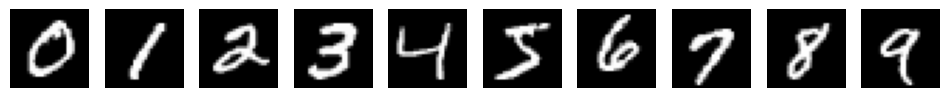

In [66]:
plt.figure(figsize=(12, 6))
for i in range(10):
    # Plot benign example
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [93]:
test = [[1,0,0,0,0,0,0,0,0,0],
        [0,1,0,0,0,0,0,0,0,0],
        [0,0,1,0,0,0,0,0,0,0],
        [0,0,0,1,0,0,0,0,0,0],
        [0,0,0,0,1,0,0,0,0,0],
        [0,0,0,0,0,1,0,0,0,0],
        [0,0,0,0,0,0,1,0,0,0],
        [0,0,0,0,0,0,0,1,0,0],
        [0,0,0,0,0,0,0,0,1,0],
        [0,0,0,0,0,0,0,0,0,1],
    ]
test = np.array(test, dtype=np.float32)

### Targeted Attacks
Conduct targeted attack against the 10 images. Try to manipulate to any class.


In [110]:
from art.attacks.evasion import CarliniL0Method
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import CarliniLInfMethod

attack_L0 = CarliniL0Method(classifier=classifier, confidence=0.8, targeted=True, learning_rate=0.2)

attack_L2 = CarliniL2Method(classifier=classifier, confidence=0.8, targeted=True, learning_rate=0.2)

attack_Linf = CarliniLInfMethod(classifier=classifier, confidence=0.8, targeted=True, learning_rate=0.2)



In [111]:

# TODO - For reusability define a method that runs the attack against the test_images. Create the plot according to the figures in [1] also within this method.
def targeted_attack_cw_paper(attack):
    plt.clf()
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
    attack = attack.generate(x=test_images, y=test)
    prediction = classifier.predict(attack)
    for i in range(10):
        for j in range(10):
            ax[i, j].imshow(attack[j][0].reshape(28, 28), cmap='gray')
            ax[i, j].set_title('Prediction: {}'.format(np.argmax(prediction[j])))





    plt.show()



C&W L_2:   0%|          | 0/10 [00:00<?, ?it/s]

[[ 90.07014     -4.393281   -24.692553   -29.080158     1.1370283
  -15.349911    -8.647401   -14.449292     4.7425284   -9.721258  ]
 [-10.691586    40.383625    -3.1806574  -20.088833    -9.610219
   11.443317    -1.5888324   -0.89173985   5.0340037   -6.8624077 ]
 [ -6.7611084  -19.583612    75.168015     5.6616316   -5.350515
  -11.808127   -17.156208   -14.018088     4.4338107  -23.179728  ]
 [-37.094307   -13.6099415   -7.786974   105.84435     -7.9642487
    7.5897427  -56.47483    -11.494128     5.394412     9.43853   ]
 [-20.409046    15.745708   -19.716005   -28.781982    79.26989
  -20.90932    -26.374859    -1.1318125   -2.7372162   13.299665  ]
 [ -8.49286      2.5183313   -1.9622458    2.1851583  -18.049618
   15.51157      4.4623046  -10.422663     2.4231215    4.050308  ]
 [ 12.971075   -26.011803     3.1462564  -37.736362    11.635273
   22.116749    94.72473    -77.51936     21.92614      2.917813  ]
 [-17.223701    18.860018     2.2325542    4.2830043    0.17669648
 

<Figure size 640x480 with 0 Axes>

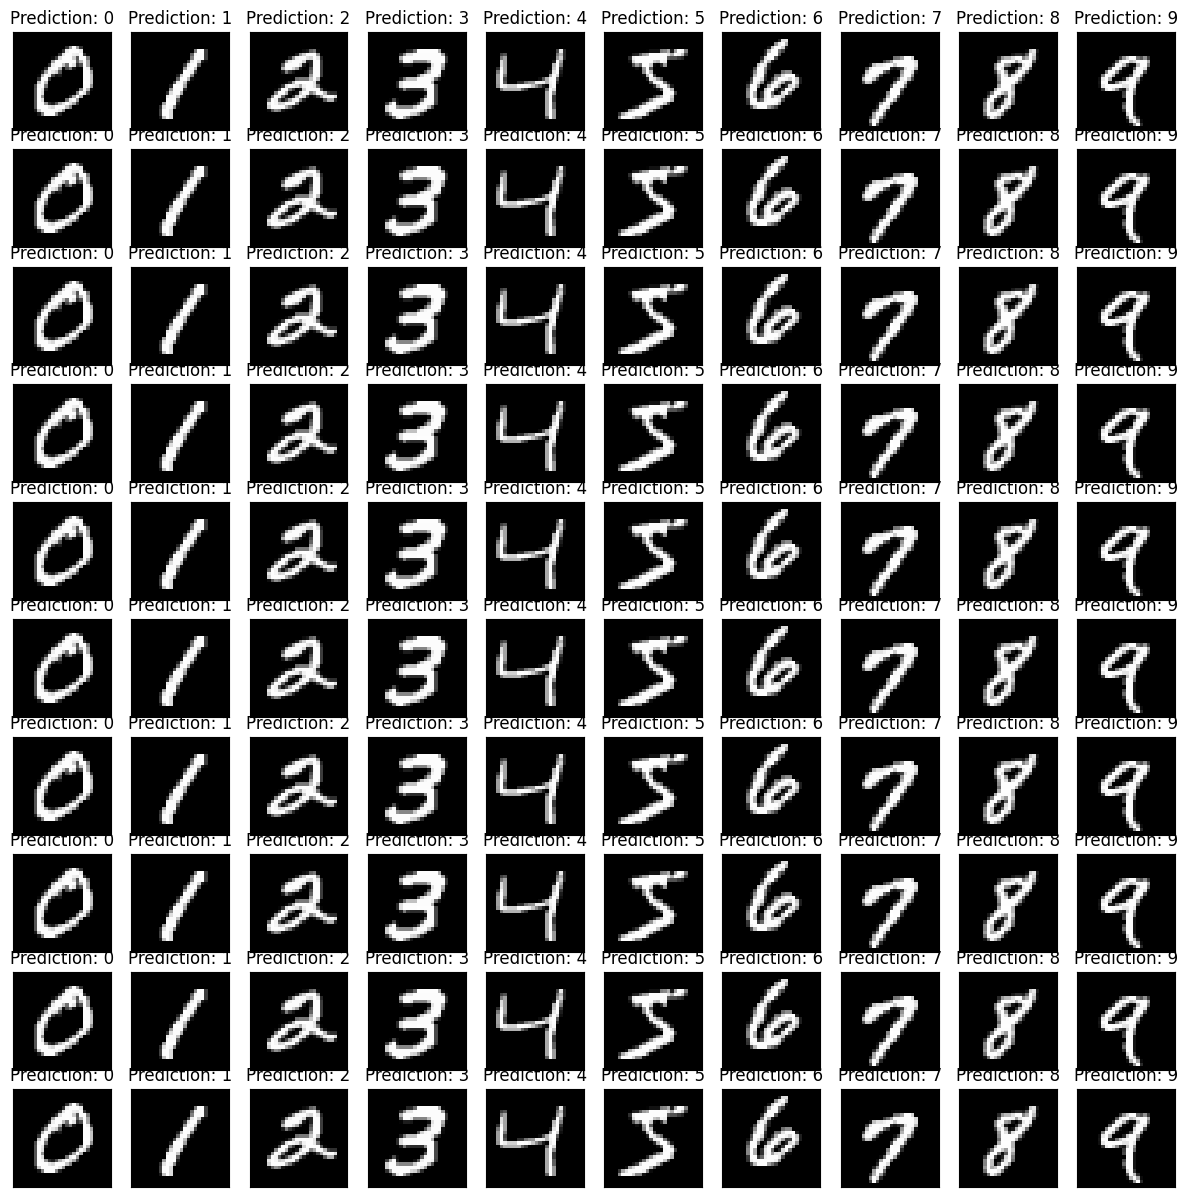

In [113]:
targeted_attack_cw_paper(attack_L2)